<a href="https://colab.research.google.com/github/WannaGetDSJobInSanFrancisco/Machine_Notebooks/blob/main/Pretrained_Models_to_TokenTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate TokenTransformer from Pretrained Models

## init

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.0 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 42.5 MB/s 
     |████████████████████████████████| 895 kB 27.1 MB/s 
     |████████████████████████████████| 596 kB 40.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from typing import Optional, List

import matplotlib.pyplot as plt
from PIL import Image
import requests
from transformers import ViTFeatureExtractor, ViTModel
# DETR
import torch
from torch import nn
from torch import Tensor
import torchvision
import torchvision.transforms as T
from torchvision import _is_tracing
# lxmert
from transformers import LxmertTokenizer, LxmertModel

%matplotlib inline

In [ ]:
txt = "Two cats sleepling in pink bed with two remotes."

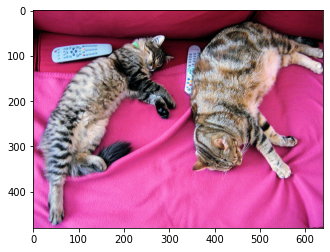

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(im)

## [DETR](https://github.com/facebookresearch/detr)
- [tutorial code](https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=ib4IT2yvYTEc) for reference

In [ ]:
# basics
## standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();
## mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
print(img.shape)
## propagate through the model
outputs = model(img)
print(outputs['pred_logits'].shape)
print(outputs['pred_boxes'].shape)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


torch.Size([1, 3, 800, 1066])
torch.Size([1, 100, 92])
torch.Size([1, 100, 4])


In [ ]:
# basics
## standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
# model = model.backbone
# model = nn.Sequential(*[list(model.children())[i] for i in range(len(list(model.children())))])
# model = nn.Sequential(*[list(model.children())[len(list(model.children()))-(i+1)] for i in range(len(list(model.children())))])
# model = model.transformer.encoder#.layers[0]
model.eval();
## mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
print(img.shape)
## format tensor
### https://github.com/facebookresearch/detr/blob/eb9f7e03ed8e2ed2cd55528989fe7df890bc3fc0/util/misc.py#L306
def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes
class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)

    # def __ntsize__(self):
    #     return self.tensors.shape
def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:
        if _is_tracing():
        # if torchvision._is_tracing():
            # nested_tensor_from_tensor_list() does not export well to ONNX
            # call _onnx_nested_tensor_from_tensor_list() instead
            return _onnx_nested_tensor_from_tensor_list(tensor_list)

        # TODO make it support different-sized images
        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False
    else:
        raise ValueError('not supported')
    return NestedTensor(tensor, mask)
# img = nested_tensor_from_tensor_list(img)
# print(img.shape)
## model class
class Transformer_mod(nn.Module):

    def __init__(self, model, #d_model=512, nhead=8, 
                 num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False):
        super().__init__()

        transformer = model.transformer

        self.encoder = transformer.encoder
        # self.encoder = transformer.encoder.layers[0]

        self.decoder = transformer.decoder

        # self._reset_parameters()

        self.d_model = transformer.d_model
        self.nhead = transformer.nhead

    # def _reset_parameters(self):
    #     for p in self.parameters():
    #         if p.dim() > 1:
    #             nn.init.xavier_uniform_(p)

    def forward(self, src, mask, query_embed, pos_embed):
        # flatten NxCxHxW to HWxNxC
        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)
        query_embed = query_embed.unsqueeze(1).repeat(1, bs, 1)
        mask = mask.flatten(1)

        tgt = torch.zeros_like(query_embed)
        print(src.shape)
        memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
        # memory = self.encoder(src)
        return memory
        # hs = self.decoder(tgt, memory, memory_key_padding_mask=mask,
        #                   pos=pos_embed, query_pos=query_embed)
        # return hs.transpose(1, 2), memory.permute(1, 2, 0).view(bs, c, h, w)

class DETR_mod(nn.Module):
    """ This is the DETR module that performs object detection """
    def __init__(self, model, transformer, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()

        self.num_queries = model.num_queries
        self.transformer = transformer
        hidden_dim = self.transformer.d_model
        self.class_embed = model.class_embed
        self.bbox_embed = model.bbox_embed
        self.query_embed = model.query_embed
        self.input_proj = model.input_proj
        self.backbone = model.backbone
        self.aux_loss = aux_loss

    def forward(self, samples: NestedTensor):
        """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels
            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)
        features, pos = self.backbone(samples)
        # return features, pos

        src, mask = features[-1].decompose()
        assert mask is not None
        #return self.input_proj(src), mask, self.query_embed.weight, pos[-1], src#features[-1]
        hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])#[0]
        # hs = self.transformer(self.input_proj(src))#[0]
        # hs = self.transformer(src)[0]
        return hs

        # outputs_class = self.class_embed(hs)
        # outputs_coord = self.bbox_embed(hs).sigmoid()
        # out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
        # if self.aux_loss:
        #     out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
        # return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{'pred_logits': a, 'pred_boxes': b}
                for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]
tr = Transformer_mod(model)
model = DETR_mod(model, tr)

# class DETR_mod(nn.Module):
#     """ This is the DETR module that performs object detection """
#     def __init__(self, model, aux_loss=False):
#         """ Initializes the model.
#         Parameters:
#             backbone: torch module of the backbone to be used. See backbone.py
#             transformer: torch module of the transformer architecture. See transformer.py
#             num_classes: number of object classes
#             num_queries: number of object queries, ie detection slot. This is the maximal number of objects
#                          DETR can detect in a single image. For COCO, we recommend 100 queries.
#             aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
#         """
#         super().__init__()

#         self.num_queries = model.num_queries
#         self.transformer = model.transformer
#         hidden_dim = self.transformer.d_model
#         self.transformer = self.transformer.encoder#.layers
#         self.class_embed = model.class_embed
#         self.bbox_embed = model.bbox_embed
#         self.query_embed = model.query_embed
#         self.input_proj = model.input_proj
#         self.backbone = model.backbone
#         self.aux_loss = aux_loss

#     def forward(self, samples: NestedTensor):
#         """ The forward expects a NestedTensor, which consists of:
#                - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
#                - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels
#             It returns a dict with the following elements:
#                - "pred_logits": the classification logits (including no-object) for all queries.
#                                 Shape= [batch_size x num_queries x (num_classes + 1)]
#                - "pred_boxes": The normalized boxes coordinates for all queries, represented as
#                                (center_x, center_y, height, width). These values are normalized in [0, 1],
#                                relative to the size of each individual image (disregarding possible padding).
#                                See PostProcess for information on how to retrieve the unnormalized bounding box.
#                - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
#                                 dictionnaries containing the two above keys for each decoder layer.
#         """
#         if isinstance(samples, (list, torch.Tensor)):
#             samples = nested_tensor_from_tensor_list(samples)
#         features, pos = self.backbone(samples)
#         # return features, pos

#         src, mask = features[-1].decompose()
#         assert mask is not None
#         #return self.input_proj(src), mask, self.query_embed.weight, pos[-1], src#features[-1]
#         # hs = self.transformer(self.input_proj(src), mask, self.query_embed.weight, pos[-1])[0]
#         hs = self.transformer(self.input_proj(src))#[0]
#         # hs = self.transformer(src)[0]
#         return hs

#         # outputs_class = self.class_embed(hs)
#         # outputs_coord = self.bbox_embed(hs).sigmoid()
#         # out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
#         # if self.aux_loss:
#         #     out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
#         # return out

#     @torch.jit.unused
#     def _set_aux_loss(self, outputs_class, outputs_coord):
#         # this is a workaround to make torchscript happy, as torchscript
#         # doesn't support dictionary with non-homogeneous values, such
#         # as a dict having both a Tensor and a list.
#         return [{'pred_logits': a, 'pred_boxes': b}
#                 for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]
# model = DETR_mod(model)

## propagate through the model
# a,b,c,d = model(img)
# a,b,c,d,e = model(img)
# print(a.shape)
# print(b.shape)
# print(c.shape)
# print(d.shape)
# print(e.shape)
outputs = model(img)
outputs.shape
# print(outputs.shape)
# features, pos = model(img)
# print([feature.tensors.shape for feature in features])
# print([po.shape for po in pos])
# print(outputs['pred_logits'].shape)
# print(outputs['pred_boxes'].shape)
# ## keep only predictions with 0.7+ confidence
# probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
# keep = probas.max(-1).values > 0.9

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


torch.Size([1, 3, 800, 1066])
torch.Size([850, 1, 256])


torch.Size([850, 1, 256])

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
# transformer = model.transformer#.encoder#.layers
transformer = model.transformer.encoder#.layers[0]
# outputs = transformer(a,b,c,d)
# src = torch.rand(10, 32, 256)
src = torch.rand(10, 32, 512)
outputs = transformer(src)
outputs.shape

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

AssertionError: ignored

In [ ]:
# function
class DETRForTokenTransformer(nn.Module):
    def __init__(self, embed_size=768):
        super(DETRForTokenTransformer, self).__init__()
        detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.hidden_size = detr.transformer.d_model
        self.feature_extractor = nn.Linear(embed_size, self.hidden_size)
        self.enc = detr.transformer.encoder
        self.classifier = nn.Linear(self.hidden_size, embed_size)
    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        detr_outputs = self.enc(features)
        outputs = self.classifier(detr_outputs)
        return outputs

In [ ]:
src = torch.rand(10, 32, 768)
model = DETRForTokenTransformer()
outputs = model(src)
outputs.shape

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


torch.Size([10, 32, 768])

In [ ]:
# function
class DETRForTokenTransformer(nn.Module):
    def __init__(self, embed_size=768, single_layer=False):
        super(DETRForTokenTransformer, self).__init__()
        detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.hidden_size = detr.transformer.d_model
        self.feature_extractor = nn.Linear(embed_size, self.hidden_size)
        if single_layer:
          self.enc = detr.transformer.encoder.layers[0]
        else:
          self.enc = detr.transformer.encoder
        self.classifier = nn.Linear(self.hidden_size, embed_size)
    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        detr_outputs = self.enc(features)
        outputs = self.classifier(detr_outputs)
        return outputs

In [ ]:
src = torch.rand(10, 32, 768)
model = DETRForTokenTransformer(single_layer=True)
outputs = model(src)
outputs.shape

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


torch.Size([10, 32, 768])

## [ViT](https://huggingface.co/transformers/model_doc/vit.html)
- [tutorial code](https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax_augreg.ipynb#scrollTo=TiHEFXlBbZiV) for reference

In [ ]:
# basics
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

inputs = feature_extractor(images=im, return_tensors="pt")
print(inputs["pixel_values"].shape)
outputs = model(**inputs)
last_hidden_states, pooler_output = outputs.last_hidden_state, outputs.pooler_output
print(last_hidden_states.shape)
print(pooler_output.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 768])
torch.Size([1, 768])


In [ ]:
# function
class ViTForTokenTransformer(nn.Module):
    def __init__(self):
        super(ViTForTokenTransformer, self).__init__()
        vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.enc = vit.encoder
    def forward(self, features):
        vit_outputs = self.enc(features)
        return vit_outputs['last_hidden_state'], features 
# class ViTForTokenTransformer(nn.Module):
#     def __init__(self, num_labels=100):
#         super(ViTForTokenTransformer, self).__init__()
#         self.feature_extractor =  ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
#         self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
#         self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
#         self.num_labels = num_labels
#     def forward(self, pixel_values):
#         features = self.feature_extractor(images=pixel_values, return_tensors="pt")
#         vit_outputs = self.vit(**features)
#         vit_output = vit_outputs.last_hidden_state
#         # return output
#         output = self.classifier(vit_output)
#         return output, vit_output

In [ ]:
vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').encoder.layer[0]
src = torch.rand([4, 39, 768])
vit(src)[0].shape

torch.Size([4, 39, 768])

In [ ]:
# call
model = ViTForTokenTransformer()
src = torch.rand([4, 39, 768])
output, output_org = model(src)
# output, output_org = model(im)
print(output_org.shape)
# print(output['last_hidden_state'].shape)
print(output.shape)

torch.Size([4, 39, 768])
torch.Size([4, 39, 768])


In [ ]:
# function
class ViTForTokenTransformer(nn.Module):
    def __init__(self):
        super(ViTForTokenTransformer, self).__init__()
        vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.enc = vit.encoder        
    def forward(self, features, single_layer=False):
        vit_outputs = self.enc(features)
        if single_layer:
            vit_outputs = self.enc.layer[-1](features)[0]
        else:
            vit_outputs = self.enc(features)['last_hidden_state']
        return vit_outputs

In [ ]:
# call
# model = ViTForTokenTransformer(single_layer=True)
model = ViTForTokenTransformer()
src = torch.rand([4, 39, 768])
# output = model(src, single_layer=False)
output = model(src, single_layer=True)
print(output.shape)

torch.Size([4, 39, 768])


## DETR+LXMERT

In [ ]:
# basics
## standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
detr.eval();
## mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
print(img.shape)
## propagate through the model
outputs_detr = detr(img)
print(outputs_detr['pred_logits'].shape)
print(outputs_detr['pred_boxes'].shape)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

torch.Size([1, 3, 800, 1066])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


torch.Size([1, 100, 92])
torch.Size([1, 100, 4])


In [ ]:
# model
## https://huggingface.co/transformers/model_doc/lxmert.html
tokenizer = LxmertTokenizer.from_pretrained('unc-nlp/lxmert-base-uncased')
model = LxmertModel.from_pretrained('unc-nlp/lxmert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/776 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/960M [00:00<?, ?B/s]

Some weights of the model checkpoint at unc-nlp/lxmert-base-uncased were not used when initializing LxmertModel: ['obj_predict_head.decoder_dict.obj.bias', 'answer_head.logit_fc.2.weight', 'cls.seq_relationship.weight', 'obj_predict_head.transform.dense.weight', 'answer_head.logit_fc.3.weight', 'obj_predict_head.decoder_dict.feat.weight', 'cls.predictions.transform.dense.bias', 'obj_predict_head.decoder_dict.attr.bias', 'cls.predictions.decoder.weight', 'obj_predict_head.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.bias', 'answer_head.logit_fc.2.bias', 'answer_head.logit_fc.0.weight', 'obj_predict_head.decoder_dict.feat.bias', 'obj_predict_head.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'answer_head.logit_fc.0.bias', 'answer_head.logit_fc.3.bias', 'obj_predict_head.decoder_dict.obj.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'obj_predict_head.decoder_dict.attr.weight', 'obj_pr

In [ ]:
# resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet = torchvision.models.resnet152(pretrained=True)
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(im)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

with torch.no_grad():
    output = resnet(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0].shape)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = nn.functional.softmax(output[0], dim=0)
print(probabilities.shape)

torch.Size([1000])
torch.Size([1000])


In [ ]:
# https://pytorch.org/hub/pytorch_vision_resnet/
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

In [ ]:
# native codes
inputs = tokenizer(txt, return_tensors="pt")

# print([inputs["input_ids"].shape, outputs_detr['pred_logits'].shape, outputs_detr['pred_boxes'].shape])
# outputs = model(input_ids=inputs["input_ids"], visual_feats=outputs_detr['pred_logits'], visual_pos=outputs_detr['pred_boxes'])

tmp_feats, tmp_pos = torch.rand([1, 100, 2048]), torch.rand([1, 100, 4])
outputs = model(input_ids=inputs["input_ids"], visual_feats=tmp_feats, visual_pos=tmp_pos)
print(outputs.keys())
print([outputs['language_output'].shape, outputs['vision_output'].shape, outputs['pooled_output'].shape])

# last_hidden_states = outputs.last_hidden_state
# print("last_hidden_states: ", len(last_hidden_states))

RuntimeError: ignored

In [ ]:
'''
# https://arxiv.org/abs/1908.07490
Object-Level Image Embeddings Instead of
using the feature map output by a convolutional
neural network, we follow Anderson et al. (2018)
in taking the features of detected objects as the embeddings of images. Specifically, the object detector detects m objects {o1, . . . , om} from the image (denoted by bounding boxes on the image in
Fig. 1). Each object oj is represented by its position feature (i.e., bounding box coordinates) pj
and its 2048-dimensional region-of-interest (RoI)
feature fj . Instead of directly using the RoI feature
fj without considering its position pj in Anderson
et al. (2018), we learn a position-aware embedding
vj by adding outputs of 2 fully-connected layers:

'''

In [ ]:
'''
# https://huggingface.co/transformers/model_doc/lxmert.html
## input_ids (torch.LongTensor of shape (batch_size, sequence_length)) –
Indices of input sequence tokens in the vocabulary.
Indices can be obtained using LxmertTokenizer. See transformers.PreTrainedTokenizer.encode() and transformers.PreTrainedTokenizer.__call__() for details.

## visual_feats –
(torch.FloatTensor of shape :obj:՝(batch_size, num_visual_features, visual_feat_dim)՝): 
This input represents visual features. They ROI pooled object features from bounding boxes using a faster-RCNN model)

## visual_pos –
(torch.FloatTensor of shape :obj:՝(batch_size, num_visual_features, visual_pos_dim)՝): 
This input represents spacial features corresponding to their relative (via index) visual features. The pre-trained LXMERT model expects these spacial features to be normalized bounding boxes on a scale of 0 to 1.
'''

In [ ]:
# function
class LXMERTForTokenTransformer(nn.Module):
    def __init__(self):
        super(LXMERTForTokenTransformer, self).__init__()
        tokenizer = LxmertTokenizer.from_pretrained('unc-nlp/lxmert-base-uncased')
        feature_extractor = 
        lxmert = LxmertModel.from_pretrained('unc-nlp/lxmert-base-uncased')
        self.enc = vit.encoder        
    def forward(self, features, single_layer=False):
        vit_outputs = self.enc(features)
        if single_layer:
            vit_outputs = self.enc.layer[-1](features)[0]
        else:
            vit_outputs = self.enc(features)['last_hidden_state']
        return vit_outputs

In [ ]:
# model
## https://huggingface.co/transformers/model_doc/lxmert.html
tokenizer = LxmertTokenizer.from_pretrained('unc-nlp/lxmert-base-uncased')
model = LxmertModel.from_pretrained('unc-nlp/lxmert-base-uncased')

In [ ]:
# native codes
inputs = tokenizer(txt, return_tensors="pt")
print([inputs["input_ids"].shape, outputs_detr['pred_logits'].shape, outputs_detr['pred_boxes'].shape])
# outputs = model(input_ids=inputs["input_ids"], visual_feats=outputs_detr['pred_logits'], visual_pos=outputs_detr['pred_boxes'])

tmp_feats, tmp_pos = torch.rand([1, 100, 2048]), torch.rand([1, 100, 4])
outputs = model(input_ids=inputs["input_ids"], visual_feats=tmp_feats, visual_pos=tmp_pos)
print(outputs.keys())
print([outputs['language_output'].shape, outputs['vision_output'].shape, outputs['pooled_output'].shape])

# last_hidden_states = outputs.last_hidden_state
# print("last_hidden_states: ", len(last_hidden_states))